In [1]:
import math
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [98]:
def calV_3D(N, ens, mc, S_array):
  '''
  Calculate the diversity of group opinions.
  The value of 'calV_3D' is a kind of an electric potential energy,
  If a group has high energy, the group opinions are diverse: this point is different from the normal Thomson problem.
  '''

  # Choose the V_max which depends on the N
  V_max_list = np.array([1.4142135623730951, 3.9481594714802353, 7.666977259633668, 12.49614444572656, 18.511218397802732, 25.619490892577677, 33.89610553620064, 43.30531859956281, 53.851507919120344])
  V_max = V_max_list[N-2]

  # Calculate V (mass of external field)
  V = 0
  for i in range(N):
    for j in range(N):
      if i == j:
        continue
      a = S_array[mc,ens,i,:]
      b = S_array[mc,ens,j,:]
      cos_t = np.round(np.dot(a, b),10)
      t = (2-2*cos_t)**0.5
      V += t**0.5

  return 0.5*V/V_max

In [99]:
def run(Sarray, N, T, alpha, ENS_step, MC_step):
  '''
  N =         No. of agents
  alpha =     Exponent
  ENS_step =  Ensemble
  MC_step =   (Macro) Step
  '''
  S_array = Sarray
  V_array = np.zeros((MC_step, ENS_step))           # V(t)
  del_S_array = np.zeros((MC_step, ENS_step, N))       # delS(t)

  for mc in range(MC_step):
    for ens in range(ENS_step):

      # 1. Initialize
      if mc == 0:
        V_array[mc,ens] = calV_3D(N, ens, mc, S_array)

      # 2. Interact
      else:
        V = V_array[mc-1,ens]
        for i in range(N):
          # 1. Calculate Group Opinion (S_G)
          e = np.array([0.0, 0.0, 1.0])
          v_i = np.array([0.0, 0.0, 0.0])
          for j in range(N):
            si_sj = np.dot(S_array[mc-1,ens,i,:], S_array[mc-1,ens,j,:])
            v_ij = 0.5*(1+si_sj)*S_array[mc-1,ens,j,:]
            v_i += v_ij
          v_i += (N**alpha)*V*e
          v_i_n = np.linalg.norm(v_i)
          v_f = v_i/v_i_n

          # 2. Calculate Prob lambda
          if mc <= T:
            rT = np.sum(S_array[0:mc,ens,i,:], axis=0)
          else:
            rT = np.sum(S_array[mc-T:mc,ens,i,:], axis=0)
          M = np.linalg.norm(rT)
          Th = np.arccos(np.round(np.dot(rT/M, v_f),10))
          Lamb = 1/(1+M*Th)

          # 3. Spin
          p = np.random.rand()
          # 3-1. Change Spins
          if p <= Lamb:
            S_array[mc,ens,i,:] = v_f
          # 3-2. Retain Spins
          else:
            S_array[mc,ens,i,:] = S_array[mc-1,ens,i,:]
          del_S_array[mc,ens,i] = np.linalg.norm(S_array[mc,ens,i,:] - S_array[mc-1,ens,i,:])
          V_array[mc,ens] = calV_3D(N, ens, mc, S_array)

  return S_array, V_array, del_S_array

# DATA2

In [100]:
N = 4
T = 10
alpha = 0.5
MC_step = 100
ENS_step = 1000

V_tar_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Score_lst = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

Savg_df = np.zeros((len(V_tar_lst), len(Score_lst)))
Sstd_df = np.zeros((len(V_tar_lst), len(Score_lst)))
Vavg_df = np.zeros((len(V_tar_lst), len(Score_lst)))
Vstd_df = np.zeros((len(V_tar_lst), len(Score_lst)))

for v, V_tar in enumerate(V_tar_lst):
  for s, Score_tar in enumerate(Score_lst):
    S_array = []
    V_array = []
    del_S_array = []

    with open(f"Sarray_N{N}_Score{Score_tar}_Vt{V_tar}.pkl","rb") as f:
        Sarray = pickle.load(f)
        
    S_array, V_array, del_S_array = run(Sarray, N, T, alpha, ENS_step, MC_step)
    
    Savg_df[v, s] = S_array[-1, :, :,2].mean(1).mean()
    Sstd_df[v, s] = np.std(S_array[-1, :, :,2].mean(1))/(ENS_step**0.5)
    Vavg_df[v, s] = V_array[-1,:].mean()
    Vstd_df[v, s] = np.std(V_array[-1,:].mean())/(ENS_step**0.5)
    


with open(f"Savg.pkl","wb") as f:
    pickle.dump(Savg_df, f)
with open(f"Sstd.pkl","wb") as f:
    pickle.dump(Sstd_df, f)
with open(f"Vavg.pkl","wb") as f:
    pickle.dump(Vavg_df, f)
with open(f"Vstd.pkl","wb") as f:
    pickle.dump(Vstd_df, f)

In [108]:
Savg_df

array([[-0.43905529, -0.32727572, -0.22068692, -0.12122524, -0.01633307,
         0.0773309 ,  0.16718895,  0.26654694,  0.35838611,  0.45250665,
         0.54351454],
       [-0.27291967, -0.15888731, -0.06058486,  0.02924266,  0.13788048,
         0.21604804,  0.28547966,  0.37154557,  0.44782095,  0.5176886 ,
         0.59675993],
       [-0.05206458,  0.06416123,  0.15867063,  0.22027989,  0.29157057,
         0.36933543,  0.42085766,  0.47066453,  0.53764998,  0.59388712,
         0.66005141],
       [ 0.37892514,  0.4464221 ,  0.5097267 ,  0.53882651,  0.56788496,
         0.58952996,  0.6199872 ,  0.66605543,  0.68615152,  0.71628251,
         0.74936606],
       [ 0.63603433,  0.66496967,  0.65847507,  0.67774404,  0.69705713,
         0.70643635,  0.71810864,  0.74941694,  0.75810916,  0.77805416,
         0.80486418],
       [ 0.71683255,  0.74568137,  0.74622802,  0.75160565,  0.7721093 ,
         0.77420024,  0.78607266,  0.79931495,  0.81153111,  0.83273108,
         0.857

In [4]:
Savg_df = np.array([[-0.43905529, -0.32727572, -0.22068692, -0.12122524, -0.01633307,
         0.0773309 ,  0.16718895,  0.26654694,  0.35838611,  0.45250665,
         0.54351454],
       [-0.27291967, -0.15888731, -0.06058486,  0.02924266,  0.13788048,
         0.21604804,  0.28547966,  0.37154557,  0.44782095,  0.5176886 ,
         0.59675993],
       [-0.05206458,  0.06416123,  0.15867063,  0.22027989,  0.29157057,
         0.36933543,  0.42085766,  0.47066453,  0.53764998,  0.59388712,
         0.66005141],
       [ 0.37892514,  0.4464221 ,  0.5097267 ,  0.53882651,  0.56788496,
         0.58952996,  0.6199872 ,  0.66605543,  0.68615152,  0.71628251,
         0.74936606],
       [ 0.63603433,  0.66496967,  0.65847507,  0.67774404,  0.69705713,
         0.70643635,  0.71810864,  0.74941694,  0.75810916,  0.77805416,
         0.80486418],
       [ 0.71683255,  0.74568137,  0.74622802,  0.75160565,  0.7721093 ,
         0.77420024,  0.78607266,  0.79931495,  0.81153111,  0.83273108,
         0.85740761],
       [ 0.78950823,  0.8006337 ,  0.80022389,  0.8078828 ,  0.8108476 ,
         0.82489696,  0.83084352,  0.84147742,  0.8552307 ,  0.86923856,
         0.89732134],
       [ 0.84830263,  0.8475771 ,  0.85269695,  0.85027447,  0.85827097,
         0.86637754,  0.86941786,  0.88369838,  0.89134574,  0.91295408,
         0.93360362],
       [ 0.94353647,  0.92847015,  0.92007579,  0.92106806,  0.91500202,
         0.9188874 ,  0.92104825,  0.92994342,  0.94139065,  0.95516129,
         0.97143327]])

In [109]:
Sstd_df

array([[0.0043824 , 0.00496079, 0.00495218, 0.00445235, 0.00448009,
        0.0036833 , 0.00257066, 0.00245776, 0.00182356, 0.00152302,
        0.00096916],
       [0.01154661, 0.01096329, 0.00996222, 0.00886561, 0.00851999,
        0.00737653, 0.00583975, 0.00502588, 0.00394621, 0.00263728,
        0.0018089 ],
       [0.01536969, 0.01421803, 0.01296722, 0.01139598, 0.00987271,
        0.0087757 , 0.00715454, 0.00569332, 0.00460916, 0.00331264,
        0.00241861],
       [0.01562305, 0.013734  , 0.01206127, 0.01057167, 0.00917365,
        0.00798468, 0.00676596, 0.00544203, 0.00447268, 0.0034004 ,
        0.00246223],
       [0.01066075, 0.00915407, 0.00857907, 0.00758535, 0.00670647,
        0.00579927, 0.00507937, 0.00410081, 0.00343558, 0.00278441,
        0.00202123],
       [0.00727527, 0.00580191, 0.00559889, 0.0047305 , 0.00412634,
        0.00351868, 0.00309077, 0.0025888 , 0.00231249, 0.0018878 ,
        0.00145487],
       [0.00453159, 0.00356184, 0.00323081, 0.00292702, 0.

In [110]:
Vavg_df

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.10767528e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.16349728e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+

In [111]:
Vstd_df

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# plot

reference:

- https://rfriend.tistory.com/419
- https://www.delftstack.com/ko/howto/python-pandas/numpy-arrays-to-pandas-dataframe/

In [106]:
Savg_new = np.zeros((11,9))
Sstd_new = np.zeros((11,9))

for v, V_tar in enumerate(V_tar_lst):
  for s, Score_tar in enumerate(Score_lst):
    Savg_new[s, v] = Savg_df[v, 10-s]
    Sstd_new[s, v] = Sstd_df[v, 10-s]

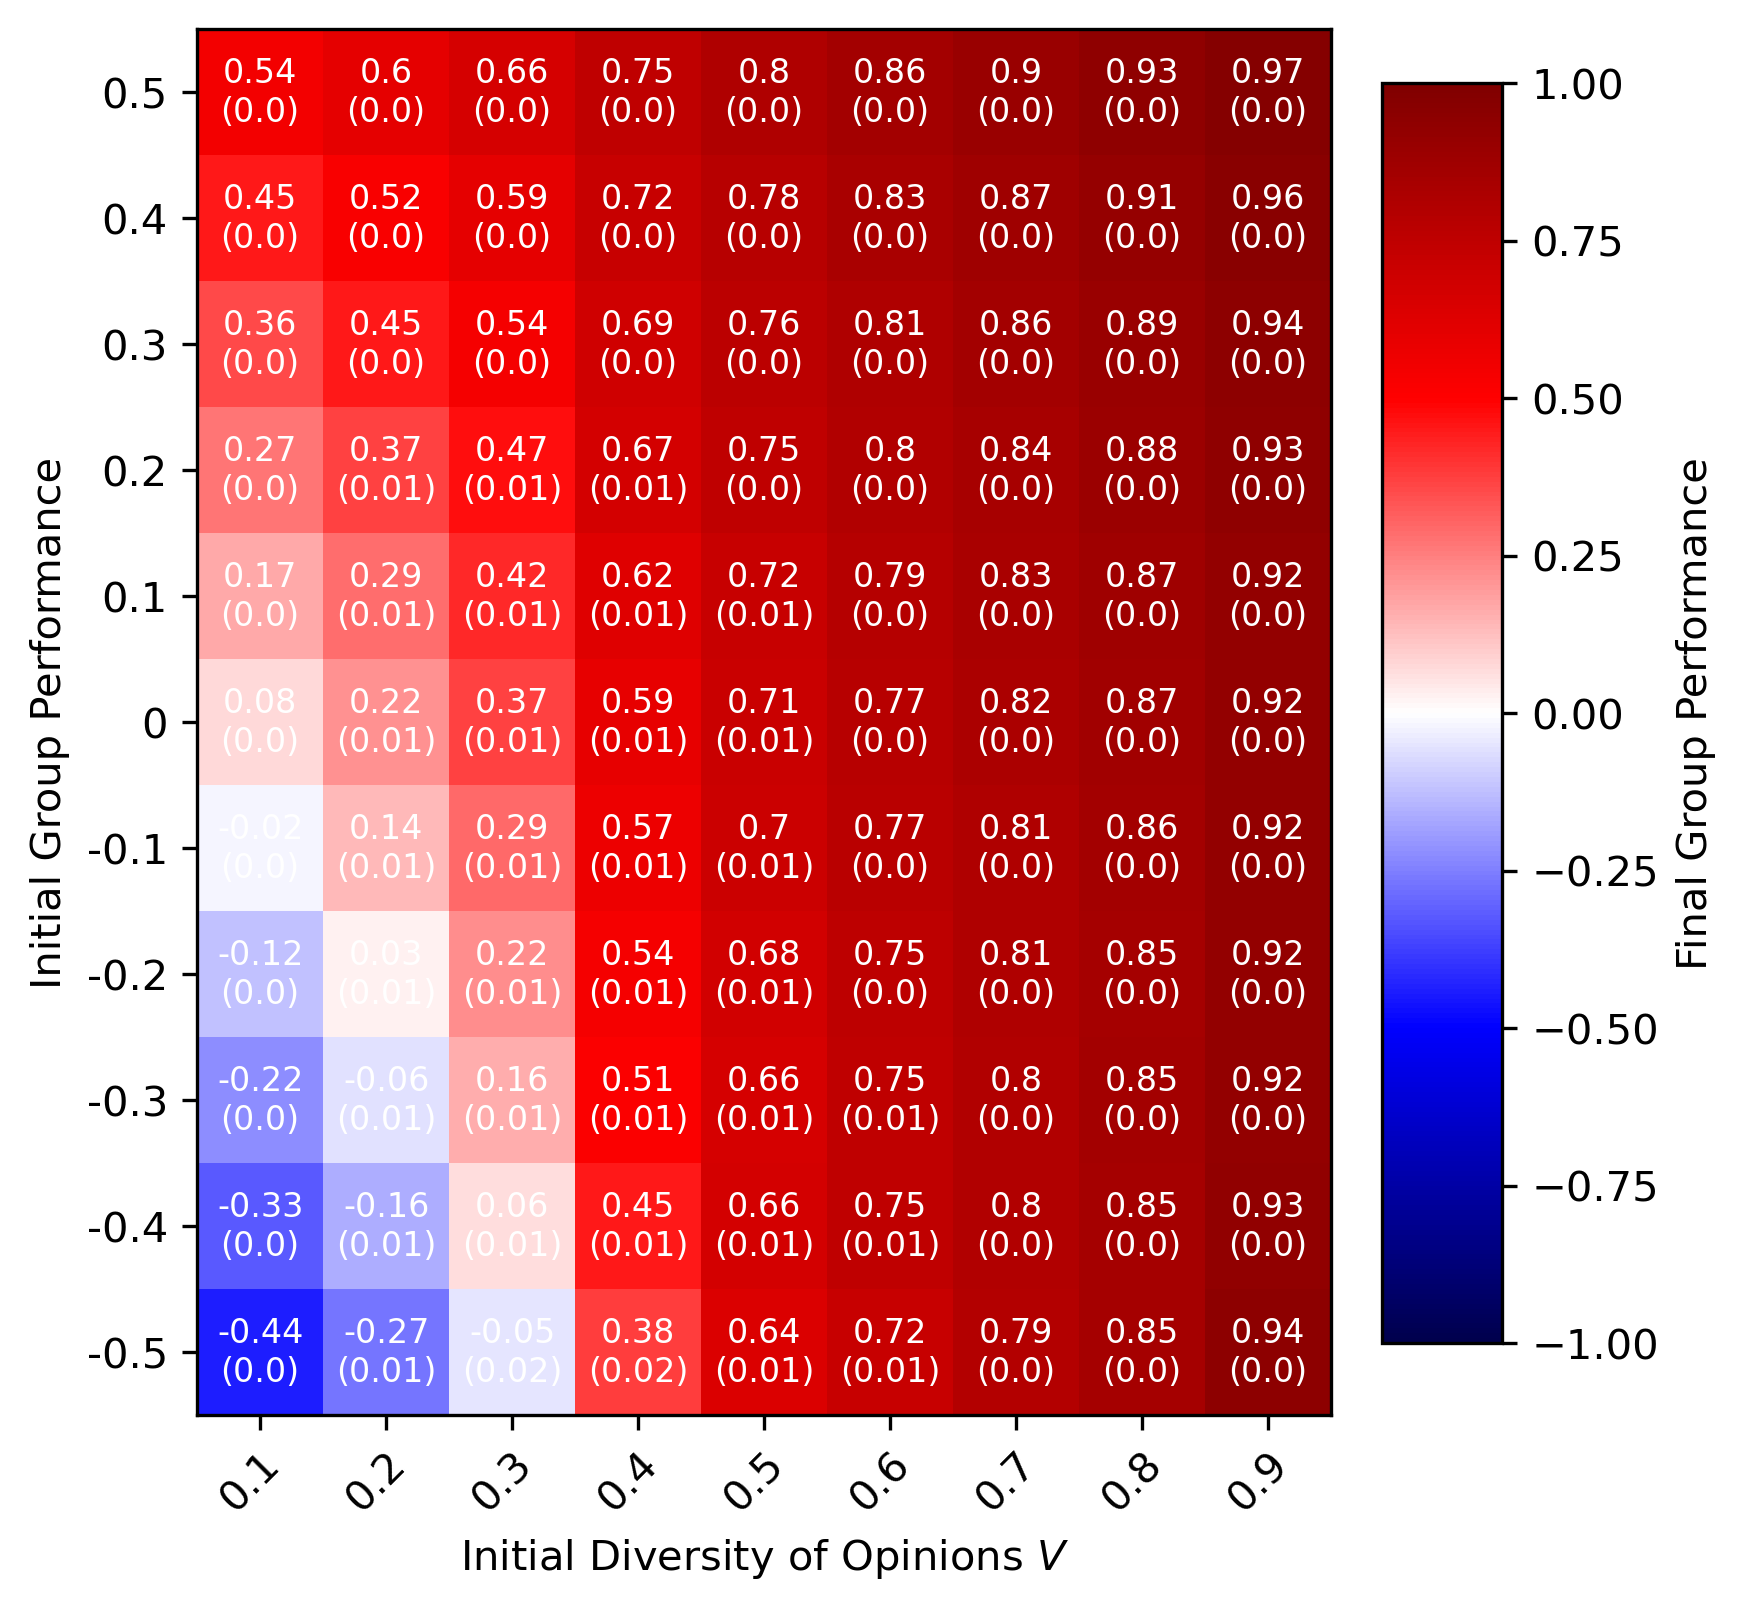

In [107]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(8,6), dpi=300)

S_avg = Savg_new
S_std = Sstd_new

row_indices = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
row_indices.reverse()
column_names = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

im = axs.imshow(S_avg, vmin=-1, vmax=1, cmap='seismic')
# Show all ticks and label them with the respective list entries
axs.set_xticks(np.arange(len(column_names)), labels=column_names)
axs.set_yticks(np.arange(len(row_indices)), labels=row_indices)

# Rotate the tick labels and set their alignment.
plt.setp(axs.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(row_indices)):
    for j in range(len(column_names)):
        text = axs.text(j, i, f'{np.around(S_avg[i, j],2)}\n({np.around(S_std[i, j],2)})', ha="center", va="center", color="w", fontsize=8)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.72, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Final Group Performance')

axs.set_xlabel(r'Initial Diversity of Opinions $V$')
axs.set_ylabel(r'Initial Group Performance')

plt.show()

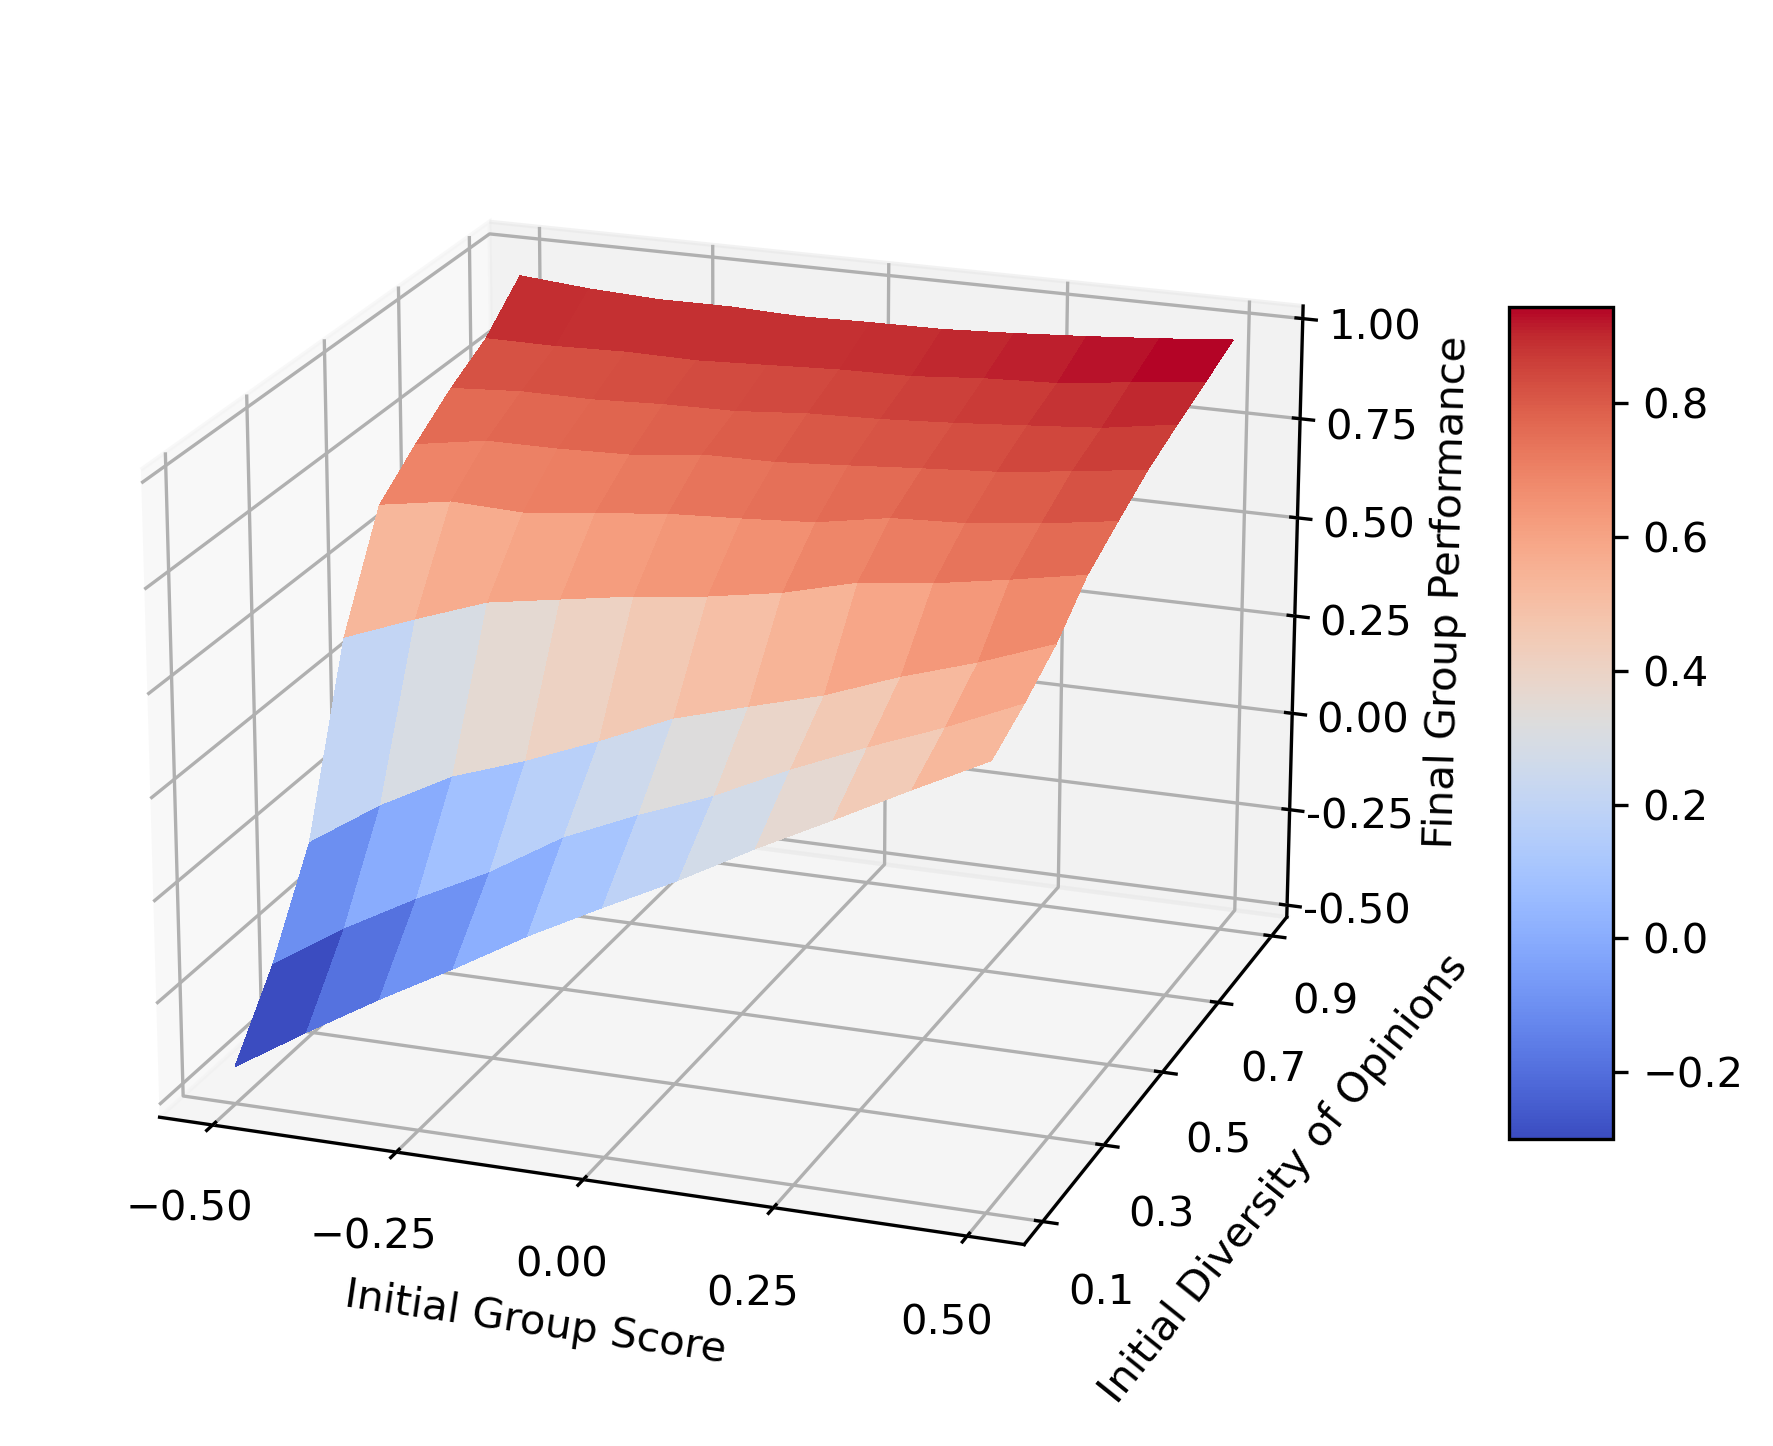

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6), dpi=300)

# Make data.

row_indices = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
column_names = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

X = row_indices
Y = column_names
X, Y = np.meshgrid(X, Y)
Z = Savg_df

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax.set_zticks([-0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])
ax.zaxis.set_major_locator(LinearLocator(7))
ax.view_init(20, 290)

ax.set_xlabel(r'Initial Group Score')
ax.set_ylabel(r'Initial Diversity of Opinions')
ax.set_zlabel('Final Group Performance')

# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.6, aspect=8)

plt.show()